In [112]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Load the dataset (replace with your actual file path)
#df = pd.read_csv('data/2024-06-01_2024-09-01/aggregated/percent_return.csv')
#df = pd.read_csv('data/2024-08-20_2024-08-28/aggregated/percent_return.csv')
df = pd.read_csv('data/2023-09-01_2024-09-01/aggregated/percent_return.csv') # 1 year's worth of data

# Extract stock names
stock_names = df.columns[1:]  # Assuming the first column is the date

print(df) #every 5th row is a friday

           date         A      AAPL      ABBV      ABNB       ABT      ACGL  \
0    2023-09-01 -1.503567 -0.634179 -3.938199 -0.755418 -3.014961 -5.413717   
1    2023-09-05 -3.244782  0.131087 -6.026389  0.807651 -4.298783 -6.135115   
2    2023-09-06 -1.216784 -3.514430 -4.803030  0.703229 -1.965424 -4.334456   
3    2023-09-07 -2.310238  0.731756 -2.678855  2.886897 -3.758249 -2.991656   
4    2023-09-08 -2.599407 -0.713180 -4.469852  1.306103 -2.370315 -5.570154   
..          ...       ...       ...       ...       ...       ...       ...   
246  2024-08-26 -0.597613  0.075116 -0.852487 -0.975609 -0.504397 -4.473917   
247  2024-08-27  0.281703  0.787340 -1.829459  1.248911 -0.433869 -4.121840   
248  2024-08-28 -0.490496 -0.736622 -0.853125  1.318964 -0.645085 -4.987173   
249  2024-08-29  0.164316 -0.244479 -1.207289 -1.328594 -0.943459 -3.602750   
250  2024-08-30  0.374815 -0.626294 -0.253636  0.316397 -0.231265 -4.809146   

          ACN      ADBE       ADI  ...      REGN   

In [113]:
# Prepare the data for Monday to Thursday (features) and Friday (target)
X = []
y = []

# Iterate over the dataset in chunks of 5 rows (representing one week)
for i in range(0, len(df), 5):
    if i + 4 >= len(df):  # Prevent going out of bounds
        break
    # Monday to Thursday data (features)
    X.extend(df.iloc[i:i+4, 1:].T.values.tolist()) # rows are companies
    #X += df.iloc[i:i+4, 1:].T.values
    # Friday data (target)
    y.extend(df.iloc[i+4, 1:].T.values.tolist())  # Friday returns as target

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Train-test split (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import numpy as np

# Define the parameter distributions
param_dist = {
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2],
    'gamma': [0, 2, 4, 6, 8, 10],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_delta_step': [0, 2, 4, 6, 8, 10],
    'n_estimators': [100, 150, 200, 250, 300],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'alpha': [0, 1, 2, 5, 10],  # L1 regularization
    'lambda': [1, 2, 4, 6, 8, 10],  # Adjusted L2 regularization
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings to sample
    scoring='r2',  # Optimize for R^2 score
    cv=TimeSeriesSplit(n_splits=5),  # 5-fold cross-validation, with time series(stock data)
    random_state=42,  # For reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the random search
random_search.fit(X_train, y_train)

# Output best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)

# Retrieve the best model
best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

# Evaluate the model on the test set
predictions = best_model.predict(X_test)

Best Parameters: {'subsample': 0.5, 'n_estimators': 150, 'min_child_weight': 7, 'max_depth': 4, 'max_delta_step': 10, 'learning_rate': 0.04, 'lambda': 10, 'gamma': 8, 'alpha': 2}
Best R^2 Score: 0.41708437054801656


In [115]:
from sklearn.dummy import DummyRegressor

# Baseline model that predicts the mean y for all feature values
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)

In [116]:
# Calculate R^2 scores
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='r2')
print("Cross-Validation Scores (Training Data):", cv_scores)
print("Mean CV R^2 Score:", np.mean(cv_scores))

# Evaluate on test set
test_r2 = r2_score(y_test, best_model.predict(X_test))
print("Test R^2 Score:", test_r2)

baseline_r2 = r2_score(y_test, baseline_predictions) # should be 0, since it predicts the mean
print(f"Baseline R^2 Score: {baseline_r2}")


Cross-Validation Scores (Training Data): [0.39108457 0.44791655 0.40307491 0.43847181 0.40487402]
Mean CV R^2 Score: 0.41708437054801656
Test R^2 Score: 0.4049928380901797
Baseline R^2 Score: -1.588487338111122e-05


In [117]:
### Model evaluation
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse}")

# Calculate RMSE for baseline
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Baseline RMSE:", baseline_rmse)
print("Model Improvement:", baseline_rmse - rmse)

Model RMSE: 1.5547858998344166
Baseline RMSE: 2.0156398972819787
Model Improvement: 0.46085399744756206


In [118]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse:.2f}")

# Calculate Baseline RMSE
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Model Improvement: {baseline_rmse - rmse:.2f}")

# Daily change standard deviation
daily_changes = np.diff(y_test).std()
print(f"Daily Change Std Dev: {daily_changes:.2f}")

Model RMSE: 1.55
Baseline RMSE: 2.02
Model Improvement: 0.46
Daily Change Std Dev: 2.84


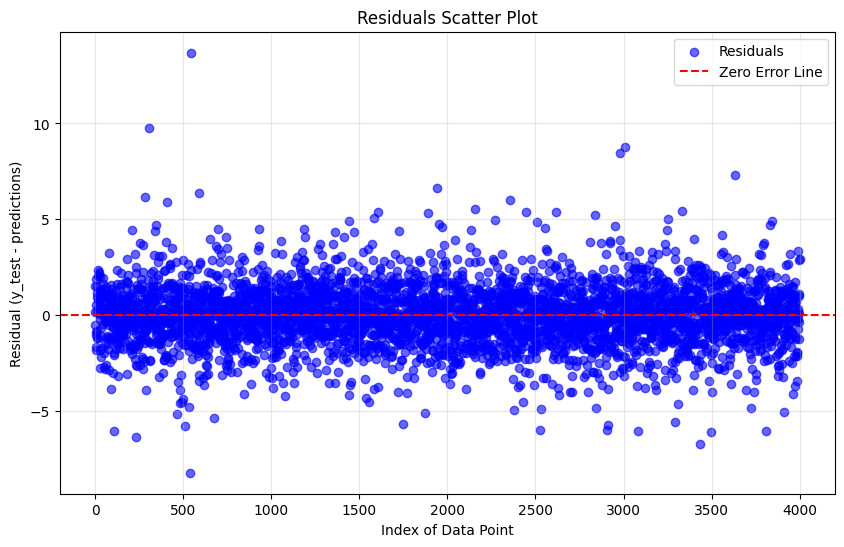

In [119]:
import matplotlib.pyplot as plt
import numpy as np

# Residuals (errors for each prediction)
residuals = y_test - predictions

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.6, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('Residual (y_test - predictions)')
plt.title('Residuals Scatter Plot')
plt.legend()
plt.grid(alpha=0.3)

plt.show()


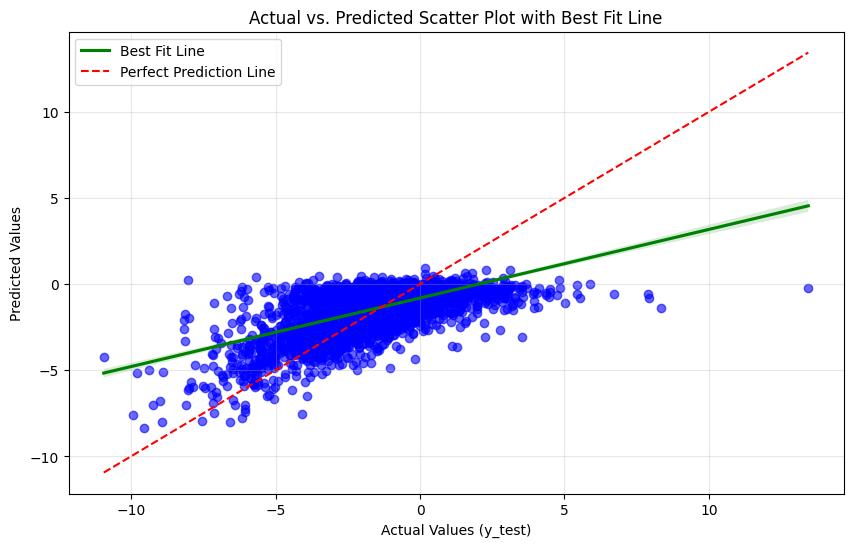

In [128]:
import seaborn as sns

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha': 0.6, 'label': 'Predicted vs. Actual'}, color='blue', line_kws={'color': 'green', 'label': 'Best Fit Line'})

# Add perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction Line')

# Labels and title
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Scatter Plot with Best Fit Line')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

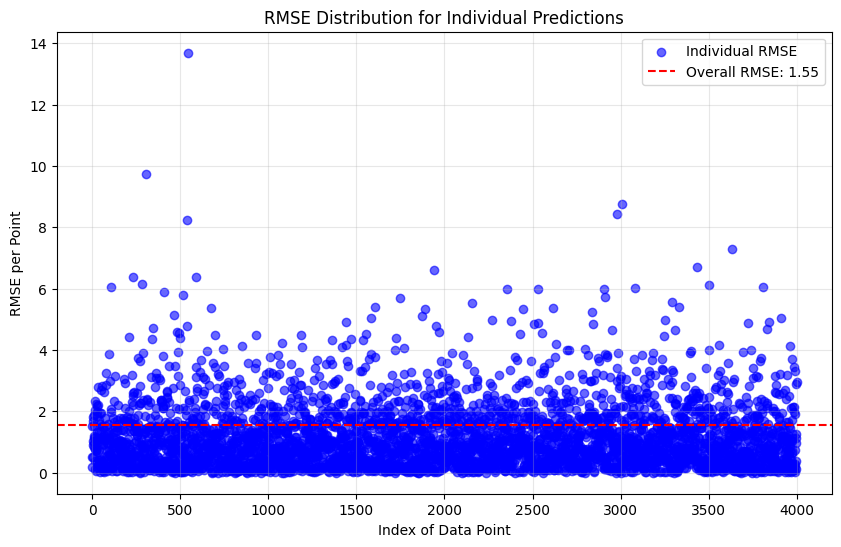

In [120]:
# Calculate individual RMSE values (absolute errors)
individual_rmse = np.sqrt((y_test - predictions) ** 2)

# Scatter plot of individual RMSE values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(individual_rmse)), individual_rmse, alpha=0.6, color='blue', label='Individual RMSE')
plt.axhline(y=rmse, color='red', linestyle='--', label=f'Overall RMSE: {rmse:.2f}')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('RMSE per Point')
plt.title('RMSE Distribution for Individual Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.show()
